✓ JAX version: 0.7.2
✓ Devices: [CudaDevice(id=0)]

JAX PINN - SOFT CONSTRAINTS WITH FIXED VS ADAPTIVE COMPARISON

RUNNING EXPERIMENT 1: Insulated BC, No Source

EXPERIMENT 1: Insulated BC (HYBRID, ADAPTIVE)

Training with ADAPTIVE weighting (SOFT CONSTRAINTS)...
  Epoch    0 | Loss: 0.190154 | U: 0.376108 | F: 0.004201 | w_u: 1.000 | w_f: 1.000
  Epoch  500 | Loss: 0.020505 | U: 0.000735 | F: 0.000325 | w_u: 0.980 | w_f: 0.980
  Epoch 1000 | Loss: 0.045306 | U: 0.000505 | F: 0.000190 | w_u: 0.956 | w_f: 0.956
  Epoch 1500 | Loss: 0.070152 | U: 0.000267 | F: 0.000128 | w_u: 0.932 | w_f: 0.932
  Final weights: w_u=0.909, w_f=0.909 (ratio 1.0:1)
  Final loss: 0.095152

RESULTS: R² = 0.9947, RMSE = 0.020109, NRMSE = 2.01%, Max Error = 0.049627, Time = 2585.5s

EXPERIMENT 1: Insulated BC (TANH, ADAPTIVE)

Training with ADAPTIVE weighting (SOFT CONSTRAINTS)...
  Epoch    0 | Loss: 0.204482 | U: 0.403164 | F: 0.005801 | w_u: 1.000 | w_f: 1.000
  Epoch  500 | Loss: 0.020501 | U: 0.000739 | F:

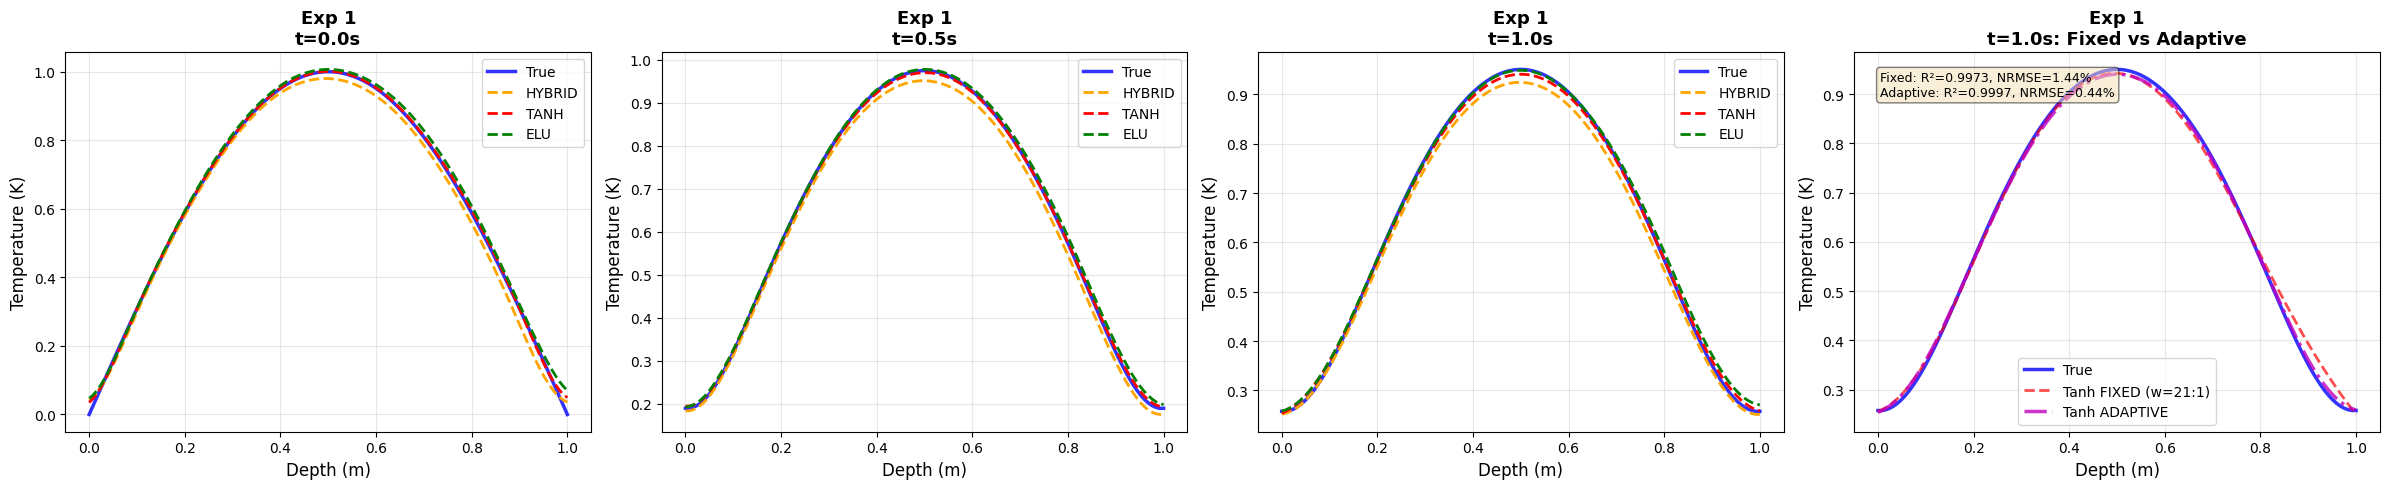

✓ Displayed: exp1_4panel_comparison

RUNNING EXPERIMENT 2: Convective BC, No Source

EXPERIMENT 2: Convective BC (HYBRID, ADAPTIVE)

Training with ADAPTIVE weighting (SOFT CONSTRAINTS)...
  Epoch    0 | Loss: 0.251010 | U: 0.497896 | F: 0.004123 | w_u: 1.000 | w_f: 1.000
  Epoch  500 | Loss: 0.025285 | U: 0.008008 | F: 0.003267 | w_u: 0.981 | w_f: 0.980
  Epoch 1000 | Loss: 0.049830 | U: 0.007748 | F: 0.003134 | w_u: 0.957 | w_f: 0.956
  Epoch 1500 | Loss: 0.074023 | U: 0.006842 | F: 0.002875 | w_u: 0.933 | w_f: 0.933
  Final weights: w_u=0.910, w_f=0.910 (ratio 1.0:1)
  Final loss: 0.098479

RESULTS: R² = 0.8797, RMSE = 0.081904, NRMSE = 8.19%, Max Error = 0.344237, Time = 2603.0s

EXPERIMENT 2: Convective BC (TANH, ADAPTIVE)

Training with ADAPTIVE weighting (SOFT CONSTRAINTS)...
  Epoch    0 | Loss: 0.265659 | U: 0.525629 | F: 0.005688 | w_u: 1.000 | w_f: 1.000
  Epoch  500 | Loss: 0.026003 | U: 0.009564 | F: 0.003161 | w_u: 0.981 | w_f: 0.980
  Epoch 1000 | Loss: 0.049500 | U: 0.00

In [ ]:
"""
================================================================================
Physics-Informed Neural Networks for Heat Equation with Source Term
================================================================================

Author: Amena Alelg
Course: CE 397 - Scientific Machine Learning
Institution: University of Texas at Austin

Reference Paper:
    Bowman, B., Oian, C., Kurz, J., Khan, T., Gil, E., & Gamez, N. (2023).
    "Physics-Informed Neural Networks for the Heat Equation with Source Term
    under Various Boundary Conditions"
    Algorithms, 16(9), 428.
    https://doi.org/10.3390/a16090428

================================================================================
IMPLEMENTATION OVERVIEW
================================================================================
Key Enhancements Over Bowman et al. (2023):

1- Framework Migration:
Re-implemented the entire paper in JAX/Flax instead of the original PyTorch implementation,
leveraging JAX's automatic differentiation and JIT compilation capabilities

2- Min-Max Normalization:
Replaced the paper's Scaling & Translation (S&T) method
with min-max normalization for Experiment 3, which:
- Eliminates the manual tuning of the scaling constant (paper used 100)
- Automatically adapts to any temperature range by normalizing to [0, 1]
- Better matches Tanh activation's natural output range

3- Adaptive Weight Balancing:
Implemented and compared adaptive weighting against the paper's fixed weights (21:1 ratio)
for balancing the soft constraint loss terms (MSE_U and MSE_f)

4- Optimizer Change:
Switched to Adam from L-BFGS - while this increases iteration count and training time,
it provides more stable gradient flow and is better supported in the JAX/Optax framework

"""

import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit
import flax.linen as nn
from flax.training import train_state
import optax
import numpy as np
import matplotlib.pyplot as plt
import time

print("✓ JAX version:", jax.__version__)
print("✓ Devices:", jax.devices())

jax.config.update('jax_enable_x64', True)

# =============================================================================
# MATERIAL PROPERTIES
# =============================================================================

class MaterialProperties:
    def __init__(self, name, conductivity, density, specific_heat, thickness=None):
        self.name = name
        self.kappa = conductivity
        self.rho = density
        self.cp = specific_heat
        self.alpha = conductivity / (density * specific_heat)
        self.thickness = thickness


def get_material_properties():
    return {
        'Mystery1': MaterialProperties('Mystery1', 500, 100, 800),
        'Epidermis': MaterialProperties('Epidermis', 0.235, 1190, 3600, 0.0008),
        'Dermis': MaterialProperties('Dermis', 0.445, 1111, 3300, 0.002),
        'Fat': MaterialProperties('Fat', 0.185, 971, 2700, 0.010)
    }


# =============================================================================
# NUMERICAL SOLVERS
# =============================================================================

def solve_heat_equation_1d(x_vals, t_vals, alpha, initial_temp_func,
                           boundary_type='insulated', T_ambient=293.15, h=10.0, kappa=500.0):
    """Solve 1D heat equation using finite difference"""
    nx = len(x_vals)
    nt = len(t_vals)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0] if nt > 1 else 0.001

    # Stability check
    r = alpha * dt / (dx ** 2)
    if r > 0.5:
        dt_internal = 0.4 * (dx ** 2) / alpha
        n_substeps = max(1, int(dt / dt_internal))
    else:
        n_substeps = 1
        dt_internal = dt

    r = alpha * dt_internal / (dx ** 2)

    # Initialize
    U = np.zeros((nx, nt))
    U[:, 0] = initial_temp_func(x_vals)

    # Time stepping
    for t_idx in range(1, nt):
        U_current = U[:, t_idx - 1].copy()

        for _ in range(n_substeps):
            U_new = U_current.copy()

            # Interior points
            U_new[1:-1] = U_current[1:-1] + r * (U_current[2:] - 2*U_current[1:-1] + U_current[:-2])

            # Boundary conditions
            if boundary_type == 'insulated':
                U_new[0] = U_new[1]
                U_new[-1] = U_new[-2]
            elif boundary_type == 'convective':
                Bi = h * dx / kappa
                U_new[0] = (U_new[1] + Bi * T_ambient) / (1 + Bi)
                U_new[-1] = (U_new[-2] + Bi * T_ambient) / (1 + Bi)

            U_current = U_new

        U[:, t_idx] = U_current

    return U


def solve_heat_equation_3layer(x_vals, t_vals, materials, irradiance=5e6, laser_duration=0.5):
    """Solve 3-layer heat equation with laser source"""
    nx = len(x_vals)
    nt = len(t_vals)
    dx = x_vals[1] - x_vals[0]
    dt = t_vals[1] - t_vals[0]

    L_epi = materials['Epidermis'].thickness
    L_derm = materials['Dermis'].thickness

    # Material properties at each point
    alpha_vals = np.zeros(nx)
    kappa_vals = np.zeros(nx)
    rho_vals = np.zeros(nx)
    cp_vals = np.zeros(nx)

    for i, x in enumerate(x_vals):
        if x < L_epi:
            mat = materials['Epidermis']
        elif x < L_epi + L_derm:
            mat = materials['Dermis']
        else:
            mat = materials['Fat']

        alpha_vals[i] = mat.alpha
        kappa_vals[i] = mat.kappa
        rho_vals[i] = mat.rho
        cp_vals[i] = mat.cp

    # Absorption coefficients
    mu_a_epi = 240.0
    mu_a_derm = 120.0
    mu_a_fat = 60.0

    # Calculate volumetric heat generation
    Q_volumetric = np.zeros(nx)
    I_current = irradiance
    cumulative_depth = 0

    for mat_name, mu_a in [('Epidermis', mu_a_epi), ('Dermis', mu_a_derm), ('Fat', mu_a_fat)]:
        if mat_name == 'Epidermis':
            thickness = L_epi
        elif mat_name == 'Dermis':
            thickness = L_derm
        else:
            thickness = materials['Fat'].thickness

        mask = (x_vals >= cumulative_depth) & (x_vals < cumulative_depth + thickness)
        local_x = x_vals[mask] - cumulative_depth
        Q_volumetric[mask] = mu_a * I_current * np.exp(-mu_a * local_x)
        I_current = I_current * np.exp(-mu_a * thickness)
        cumulative_depth += thickness

    # Stability
    Q_max_rate = Q_volumetric.max() / (rho_vals * cp_vals).min()
    dt_source_limit = 0.1 / Q_max_rate
    dt_diffusion_limit = 0.4 * (dx ** 2) / np.max(alpha_vals)
    dt_safe = min(dt, dt_diffusion_limit, dt_source_limit)
    n_substeps = max(1, int(np.ceil(dt / dt_safe)))
    dt_sub = dt / n_substeps

    # Initialize
    U = np.zeros((nx, nt))
    U[:, 0] = 310.0

    # Time stepping
    for t_idx in range(1, nt):
        t = t_vals[t_idx]
        U_current = U[:, t_idx - 1].copy()

        for sub_step in range(n_substeps):
            t_sub = t_vals[t_idx - 1] + (sub_step + 1) * dt_sub
            U_new = U_current.copy()

            # Source term
            if t_sub <= laser_duration:
                Q_rate = Q_volumetric / (rho_vals * cp_vals)
            else:
                Q_rate = np.zeros(nx)

            # Heat equation with varying properties
            for i in range(1, nx - 1):
                k_plus = (kappa_vals[i] + kappa_vals[i+1]) / 2
                k_minus = (kappa_vals[i] + kappa_vals[i-1]) / 2

                flux_plus = k_plus * (U_current[i+1] - U_current[i]) / dx
                flux_minus = k_minus * (U_current[i] - U_current[i-1]) / dx

                dT_dt = (flux_plus - flux_minus) / (dx * rho_vals[i] * cp_vals[i]) + Q_rate[i]
                U_new[i] = U_current[i] + dT_dt * dt_sub

            # Insulated boundaries
            U_new[0] = U_new[1]
            U_new[-1] = U_new[-2]

            U_current = U_new

        U[:, t_idx] = U_current

    return U, Q_volumetric


# =============================================================================
# PINN MODEL
# =============================================================================

class PINN(nn.Module):
    features: tuple
    activation_type: str = 'tanh'

    @nn.compact
    def __call__(self, x, t):
        inputs = jnp.concatenate([x, t], axis=-1)

        for i, feat in enumerate(self.features[:-1]):
            inputs = nn.Dense(feat)(inputs)

            if self.activation_type == 'hybrid' and i == len(self.features) - 2:
                inputs = nn.elu(inputs)
            elif self.activation_type == 'elu':
                inputs = nn.elu(inputs)
            else:
                inputs = nn.tanh(inputs)

        output = nn.Dense(self.features[-1])(inputs)

        if self.activation_type == 'hybrid':
            output = nn.elu(output)

        return output


class PINNModel:
    def __init__(self, hidden_layers, nodes_per_layer, alpha, activation_type='tanh', use_adaptive=True):
        self.alpha = alpha
        self.use_adaptive = use_adaptive
        self.activation_type = activation_type
        self.features = tuple([nodes_per_layer] * hidden_layers + [1])
        self.model = PINN(features=self.features, activation_type=activation_type)

        self.log_var_u = jnp.array([0.0])
        self.log_var_f = jnp.array([0.0])

    def init_params(self, rng):
        return self.model.init(rng, jnp.ones((1, 1)), jnp.ones((1, 1)))

    def predict(self, params, x, t):
        x_in = jnp.array([[x]])
        t_in = jnp.array([[t]])
        return self.model.apply(params, x_in, t_in)[0, 0]

    def pde_residual(self, params, x, t, alpha_val, Q=0.0):
        """
        Computes PDE residual: ∂u/∂t - α ∂²u/∂x² - Q = 0
        This is the SOFT CONSTRAINT on the PDE
        """
        def u(x_val, t_val):
            x_in = jnp.array([[x_val]])
            t_in = jnp.array([[t_val]])
            return self.model.apply(params, x_in, t_in)[0, 0]

        u_t = grad(u, argnums=1)(x, t)
        u_xx = grad(grad(u, argnums=0), argnums=0)(x, t)

        return u_t - alpha_val * u_xx - Q


# =============================================================================
# TRAINING (SOFT CONSTRAINTS Implementation)
# =============================================================================

def create_state(model, rng, lr=1e-3):
    params = model.init_params(rng)
    tx = optax.adam(lr)
    return train_state.TrainState.create(
        apply_fn=model.model.apply,
        params=params,
        tx=tx
    )


def train_model(model, data, n_epochs=2000):
    """
    Training with SOFT CONSTRAINTS:
    - Loss = weighted_MSE_U + weighted_MSE_f
    - MSE_U: boundary/initial conditions
    - MSE_f: PDE residuals
    """
    if len(data) == 6:
        x_bc, t_bc, u_bc, x_col, t_col, alpha_col = data
        Q_col = jnp.zeros_like(x_col)
    else:
        x_bc, t_bc, u_bc, x_col, t_col, alpha_col, Q_col = data

    rng = random.PRNGKey(42)
    state = create_state(model, rng)

    # Adaptive weights
    log_var_u = jnp.array([0.0])
    log_var_f = jnp.array([0.0])

    losses = []
    weight_history = {'u': [], 'f': []}

    def compute_loss(params, curr_log_var_u, curr_log_var_f):
        """
        SOFT CONSTRAINT LOSS FUNCTION:
        Total = weight_u * MSE_U + weight_f * MSE_f
        """
        # Boundary/Initial condition loss (MSE_U)
        u_pred = vmap(lambda x, t: model.predict(params, x, t))(x_bc, t_bc)
        loss_u = jnp.mean((u_bc - u_pred) ** 2)

        # PDE residual loss (MSE_f)
        residuals = vmap(lambda x, t, a, q: model.pde_residual(params, x, t, a, q))(
            x_col, t_col, alpha_col, Q_col
        )
        loss_f = jnp.mean(residuals ** 2)

        # Total loss with soft constraints
        if model.use_adaptive:
            # Adaptive weights (learned during training)
            prec_u = jnp.exp(-curr_log_var_u[0])
            prec_f = jnp.exp(-curr_log_var_f[0])
            total = 0.5 * prec_u * loss_u + 0.5 * prec_f * loss_f + 0.5 * (curr_log_var_u[0] + curr_log_var_f[0])
        else:
            # Fixed weights (as in paper: a1=21, a2=1)
            total = 21.0 * loss_u + 1.0 * loss_f

        return total, (loss_u, loss_f)

    method = "ADAPTIVE" if model.use_adaptive else "FIXED"
    print(f"Training with {method} weighting (SOFT CONSTRAINTS)...")

    for epoch in range(n_epochs):
        (loss, (loss_u, loss_f)), grads = jax.value_and_grad(
            lambda p: compute_loss(p, log_var_u, log_var_f), has_aux=True
        )(state.params)

        state = state.apply_gradients(grads=grads)
        losses.append(float(loss))

        if epoch % 500 == 0:
            if model.use_adaptive:
                w_u = float(jnp.exp(-log_var_u[0]))
                w_f = float(jnp.exp(-log_var_f[0]))
                print(f"  Epoch {epoch:4d} | Loss: {loss:.6f} | U: {loss_u:.6f} | F: {loss_f:.6f} | w_u: {w_u:.3f} | w_f: {w_f:.3f}")
            else:
                print(f"  Epoch {epoch:4d} | Loss: {loss:.6f} | U: {loss_u:.6f} | F: {loss_f:.6f}")

        # Update adaptive weights
        if model.use_adaptive and epoch % 100 == 0 and epoch > 0:
            grad_u = 0.5 * (jnp.exp(-log_var_u[0]) * loss_u - 1)
            grad_f = 0.5 * (jnp.exp(-log_var_f[0]) * loss_f - 1)
            log_var_u = jnp.array([log_var_u[0] - 0.01 * grad_u])
            log_var_f = jnp.array([log_var_f[0] - 0.01 * grad_f])

            weight_history['u'].append(float(jnp.exp(-log_var_u[0])))
            weight_history['f'].append(float(jnp.exp(-log_var_f[0])))

    model.log_var_u = log_var_u
    model.log_var_f = log_var_f

    if model.use_adaptive:
        final_w_u = float(jnp.exp(-log_var_u[0]))
        final_w_f = float(jnp.exp(-log_var_f[0]))
        print(f"  Final weights: w_u={final_w_u:.3f}, w_f={final_w_f:.3f} (ratio {final_w_u/final_w_f:.1f}:1)")
    else:
        print(f"  Fixed weights: w_u=21.0, w_f=1.0 (ratio 21:1)")

    print(f"  Final loss: {losses[-1]:.6f}")
    return state, losses, weight_history


def evaluate_model(model, state, X_flat, T_flat, U_true_flat):
    """Evaluate model predictions with consistent error metrics"""
    u_pred = vmap(lambda x, t: model.predict(state.params, x, t))(X_flat, T_flat)

    # Convert to numpy for calculations
    u_pred_np = np.array(u_pred)
    U_true_np = np.array(U_true_flat)

    # R² score
    ss_res = np.sum((U_true_np - u_pred_np) ** 2)
    ss_tot = np.sum((U_true_np - np.mean(U_true_np)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # RMSE (Root Mean Square Error) - absolute error
    rmse = np.sqrt(np.mean((U_true_np - u_pred_np) ** 2))

    # NRMSE (Normalized RMSE) - as percentage of temperature range
    temp_range = U_true_np.max() - U_true_np.min()
    nrmse_percent = (rmse / temp_range) * 100 if temp_range > 0 else 0

    # Max absolute error
    max_abs_error = np.max(np.abs(U_true_np - u_pred_np))

    return {
        'r2_score': float(r2),
        'rmse': float(rmse),
        'nrmse_percent': float(nrmse_percent),
        'max_abs_error': float(max_abs_error),
        'predictions': u_pred_np
    }


# =============================================================================
# EXPERIMENTS
# =============================================================================

def run_experiment_1(activation_type='tanh', use_adaptive=True):
    """Experiment 1: Insulated BC, No Source"""
    print(f"\n{'='*70}")
    print(f"EXPERIMENT 1: Insulated BC ({activation_type.upper()}, {'ADAPTIVE' if use_adaptive else 'FIXED'})")
    print(f"{'='*70}\n")

    materials = get_material_properties()
    mystery1 = materials['Mystery1']
    alpha = mystery1.alpha

    x_vals = np.linspace(0, 1, 125)
    t_vals = np.linspace(0, 1, 100)

    initial_temp = lambda x: np.sin(np.pi * x)

    U_true = solve_heat_equation_1d(x_vals, t_vals, alpha, initial_temp, 'insulated')

    # Training data
    x_ic = x_vals.copy()
    t_ic = np.zeros(125)
    u_ic = U_true[:, 0]

    n_bc = 175
    nt = len(t_vals)
    bc_idx = np.random.choice(nt, n_bc, replace=True)
    x_bc = np.concatenate([np.zeros(n_bc//2), np.ones(n_bc - n_bc//2)])
    t_bc = np.concatenate([t_vals[bc_idx[:n_bc//2]], t_vals[bc_idx[n_bc//2:]]])
    u_bc = np.concatenate([U_true[0, bc_idx[:n_bc//2]], U_true[-1, bc_idx[n_bc//2:]]])

    x_u = np.concatenate([x_ic, x_bc])
    t_u = np.concatenate([t_ic, t_bc])
    u_u = np.concatenate([u_ic, u_bc])

    # Collocation points (LHS)
    from scipy.stats import qmc
    sampler = qmc.LatinHypercube(d=2)
    coll = sampler.random(n=25000)
    x_f = coll[:, 0]
    t_f = coll[:, 1]
    alpha_f = np.full_like(x_f, alpha)

    data = tuple(jnp.array(a) for a in (x_u, t_u, u_u, x_f, t_f, alpha_f))

    model = PINNModel(10, 32, alpha, activation_type, use_adaptive)
    t0 = time.time()
    state, losses, weight_hist = train_model(model, data, n_epochs=2000)
    train_time = time.time() - t0

    X, T = np.meshgrid(x_vals, t_vals, indexing='ij')
    results = evaluate_model(model, state, X.flatten(), T.flatten(), U_true.flatten())
    results['time'] = train_time

    print(f"\nRESULTS: R² = {results['r2_score']:.4f}, RMSE = {results['rmse']:.6f}, NRMSE = {results['nrmse_percent']:.2f}%, Max Error = {results['max_abs_error']:.6f}, Time = {train_time:.1f}s")

    return results, model, state, losses, weight_hist, U_true, x_vals, t_vals


def run_experiment_2(activation_type='tanh', use_adaptive=True):
    """Experiment 2: Convective BC, No Source"""
    print(f"\n{'='*70}")
    print(f"EXPERIMENT 2: Convective BC ({activation_type.upper()}, {'ADAPTIVE' if use_adaptive else 'FIXED'})")
    print(f"{'='*70}\n")

    materials = get_material_properties()
    mystery1 = materials['Mystery1']
    alpha = mystery1.alpha

    x_vals = np.linspace(0, 1, 125)
    t_vals = np.linspace(0, 1, 100)

    initial_temp = lambda x: np.sin(np.pi * x)

    U_true = solve_heat_equation_1d(x_vals, t_vals, alpha, initial_temp,
                                    'convective', T_ambient=293.15, h=10.0, kappa=mystery1.kappa)

    x_ic = x_vals.copy()
    t_ic = np.zeros(125)
    u_ic = U_true[:, 0]

    n_bc = 1075
    nt = len(t_vals)
    bc_idx = np.random.choice(nt, n_bc, replace=True)
    x_bc = np.concatenate([np.zeros(n_bc//2), np.ones(n_bc - n_bc//2)])
    t_bc = np.concatenate([t_vals[bc_idx[:n_bc//2]], t_vals[bc_idx[n_bc//2:]]])
    u_bc = np.concatenate([U_true[0, bc_idx[:n_bc//2]], U_true[-1, bc_idx[n_bc//2:]]])

    x_u = np.concatenate([x_ic, x_bc])
    t_u = np.concatenate([t_ic, t_bc])
    u_u = np.concatenate([u_ic, u_bc])

    from scipy.stats import qmc
    sampler = qmc.LatinHypercube(d=2)
    coll = sampler.random(n=25000)
    x_f = coll[:, 0]
    t_f = coll[:, 1]
    alpha_f = np.full_like(x_f, alpha)

    data = tuple(jnp.array(a) for a in (x_u, t_u, u_u, x_f, t_f, alpha_f))

    model = PINNModel(10, 32, alpha, activation_type, use_adaptive)
    t0 = time.time()
    state, losses, weight_hist = train_model(model, data, n_epochs=2000)
    train_time = time.time() - t0

    X, T = np.meshgrid(x_vals, t_vals, indexing='ij')
    results = evaluate_model(model, state, X.flatten(), T.flatten(), U_true.flatten())
    results['time'] = train_time

    print(f"\nRESULTS: R² = {results['r2_score']:.4f}, RMSE = {results['rmse']:.6f}, NRMSE = {results['nrmse_percent']:.2f}%, Max Error = {results['max_abs_error']:.6f}, Time = {train_time:.1f}s")

    return results, model, state, losses, weight_hist, U_true, x_vals, t_vals


def run_experiment_3(activation_type='tanh', use_adaptive=True):
    """Experiment 3: 3-Layer Skin + Source"""
    print(f"\n{'='*70}")
    print(f"EXPERIMENT 3: 3-Layer Skin + Source ({activation_type.upper()}, {'ADAPTIVE' if use_adaptive else 'FIXED'})")
    print(f"{'='*70}\n")

    materials = get_material_properties()

    L_total = 0.0008 + 0.002 + 0.010
    x_vals = np.concatenate([
        np.linspace(0, 0.0008, 50, endpoint=False),
        np.linspace(0.0008, 0.0028, 40, endpoint=False),
        np.linspace(0.0028, L_total, 160)
    ])

    t_vals = np.linspace(0, 1.0, 100)

    U_true, Q_volumetric = solve_heat_equation_3layer(x_vals, t_vals, materials, 5e6, 0.5)

    print(f"Temp range: [{U_true.min():.2f}, {U_true.max():.2f}] K")

    # Min-Max Normalization for ALL activation types (prevents NaN with large temperature values)
    u_min = U_true.min()
    u_max = U_true.max()
    U_scaled = (U_true - u_min) / (u_max - u_min)
    print(f"Min-Max Normalization: (T - {u_min:.2f}) / ({u_max:.2f} - {u_min:.2f})")

    x_ic = x_vals.copy()
    t_ic = np.zeros(len(x_vals))
    u_ic = U_scaled[:, 0]

    n_bc = 175
    nt = len(t_vals)
    bc_idx = np.random.choice(nt, n_bc, replace=True)
    x_bc = np.concatenate([np.zeros(n_bc//2), np.full(n_bc - n_bc//2, L_total)])
    t_bc = np.concatenate([t_vals[bc_idx[:n_bc//2]], t_vals[bc_idx[n_bc//2:]]])
    u_bc = np.concatenate([U_scaled[0, bc_idx[:n_bc//2]], U_scaled[-1, bc_idx[n_bc//2:]]])

    x_u = np.concatenate([x_ic, x_bc])
    t_u = np.concatenate([t_ic, t_bc])
    u_u = np.concatenate([u_ic, u_bc])

    n_coll = 25000
    x_f_idx = np.random.choice(len(x_vals), n_coll, replace=True)
    t_f_idx = np.random.choice(nt, n_coll, replace=True)
    x_f = x_vals[x_f_idx]
    t_f = t_vals[t_f_idx]

    alpha_f = np.zeros(n_coll)
    Q_f = np.zeros(n_coll)

    L_epi = materials['Epidermis'].thickness
    L_derm = materials['Dermis'].thickness

    for i, (x, t) in enumerate(zip(x_f, t_f)):
        if x < L_epi:
            mat = materials['Epidermis']
        elif x < L_epi + L_derm:
            mat = materials['Dermis']
        else:
            mat = materials['Fat']

        alpha_f[i] = mat.alpha

        if t <= 0.5:
            x_idx = np.argmin(np.abs(x_vals - x))
            Q_f[i] = Q_volumetric[x_idx] / (mat.rho * mat.cp)
            # Scale Q to match min-max normalized temperature units
            Q_f[i] /= (u_max - u_min)

    data = tuple(jnp.array(a) for a in (x_u, t_u, u_u, x_f, t_f, alpha_f, Q_f))

    model = PINNModel(6, 64, materials['Epidermis'].alpha, activation_type, use_adaptive)
    t0 = time.time()
    state, losses, weight_hist = train_model(model, data, n_epochs=2000)
    train_time = time.time() - t0

    X, T = np.meshgrid(x_vals, t_vals, indexing='ij')

    u_pred_scaled = vmap(lambda x, t: model.predict(state.params, x, t))(
        X.flatten(), T.flatten()
    )

    # Unscale predictions using min-max denormalization (applied to all activation types)
    u_pred = np.array(u_pred_scaled) * (u_max - u_min) + u_min

    ss_res = np.sum((U_true.flatten() - u_pred) ** 2)
    ss_tot = np.sum((U_true.flatten() - np.mean(U_true.flatten())) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # FIXED ERROR METRICS (no more division by near-zero!)
    # 1. RMSE (Root Mean Square Error) - absolute error
    rmse = np.sqrt(np.mean((U_true.flatten() - u_pred) ** 2))

    # 2. NRMSE (Normalized RMSE) - as percentage of temperature range
    temp_range = U_true.flatten().max() - U_true.flatten().min()
    nrmse_percent = (rmse / temp_range) * 100 if temp_range > 0 else 0

    # 3. Max absolute error
    max_abs_error = np.max(np.abs(U_true.flatten() - u_pred))

    results = {
        'r2_score': r2,
        'rmse': rmse,
        'nrmse_percent': nrmse_percent,
        'max_abs_error': max_abs_error,
        'predictions': u_pred,
        'time': train_time
    }

    print(f"\nRESULTS: R² = {results['r2_score']:.4f}, RMSE = {rmse:.6f}, NRMSE = {nrmse_percent:.2f}%, Max Error = {max_abs_error:.6f}, Time = {train_time:.1f}s")

    return results, model, state, losses, weight_hist, U_true, x_vals, t_vals


# =============================================================================
# ENHANCED PLOTTING: 4-Panel Comparison
# =============================================================================

def plot_4panel_comparison(exp_num, results_dict, results_tanh_fixed, results_tanh_adaptive,
                           U_true, x_vals, t_vals):
    """
    Generate 4-panel plots (1 row × 4 columns):
    - Panel 1: t=0s (all activation functions)
    - Panel 2: t=0.5s (all activation functions)
    - Panel 3: t=1.0s (all activation functions)
    - Panel 4: t=1.0s (Tanh Fixed vs Adaptive comparison)
    """
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))

    t_start_idx = 0
    t_mid_idx = len(t_vals) // 2
    t_end_idx = -1

    colors = {'hybrid': 'orange', 'tanh': 'red', 'elu': 'green'}

    time_points = [
        (t_start_idx, 't=0.0s', axes[0]),
        (t_mid_idx, f't={t_vals[t_mid_idx]:.1f}s', axes[1]),
        (t_end_idx, 't=1.0s', axes[2])
    ]

    # Panels 1-3: Standard time evolution with all activation functions
    for t_idx, t_label, ax in time_points:
        # True solution
        ax.plot(x_vals, U_true[:, t_idx], 'b-', label='True', linewidth=2.5, alpha=0.8)

        # Predictions
        for act_type, result in results_dict.items():
            u_pred_grid = result['predictions'].reshape(len(x_vals), len(t_vals))
            ax.plot(x_vals, u_pred_grid[:, t_idx], '--',
                   label=f'{act_type.upper()}', linewidth=2,
                   color=colors.get(act_type, 'gray'))

        ax.set_xlabel('Depth (m)', fontsize=12)
        ax.set_ylabel('Temperature (K)' if exp_num != 3 else 'Temperature (K)', fontsize=12)
        ax.set_title(f'Exp {exp_num}\n{t_label}', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)

    # Panel 4: Tanh Fixed vs Adaptive at t=1.0s
    ax4 = axes[3]

    # True solution
    ax4.plot(x_vals, U_true[:, t_end_idx], 'b-', label='True', linewidth=2.5, alpha=0.8)

    # Tanh Fixed
    u_pred_fixed = results_tanh_fixed['predictions'].reshape(len(x_vals), len(t_vals))
    ax4.plot(x_vals, u_pred_fixed[:, t_end_idx], 'r--',
            label='Tanh FIXED (w=21:1)', linewidth=2, alpha=0.7)

    # Tanh Adaptive
    u_pred_adaptive = results_tanh_adaptive['predictions'].reshape(len(x_vals), len(t_vals))
    ax4.plot(x_vals, u_pred_adaptive[:, t_end_idx], 'm-.',
            label='Tanh ADAPTIVE', linewidth=2.5, alpha=0.8)

    ax4.set_xlabel('Depth (m)', fontsize=12)
    ax4.set_ylabel('Temperature (K)', fontsize=12)
    ax4.set_title(f'Exp {exp_num}\nt=1.0s: Fixed vs Adaptive', fontsize=13, fontweight='bold')
    ax4.legend(fontsize=10, loc='best')
    ax4.grid(True, alpha=0.3)

    # Add performance metrics text
    r2_fixed = results_tanh_fixed['r2_score']
    r2_adaptive = results_tanh_adaptive['r2_score']
    nrmse_fixed = results_tanh_fixed['nrmse_percent']
    nrmse_adaptive = results_tanh_adaptive['nrmse_percent']

    metrics_text = (f"Fixed: R²={r2_fixed:.4f}, NRMSE={nrmse_fixed:.2f}%\n"
                   f"Adaptive: R²={r2_adaptive:.4f}, NRMSE={nrmse_adaptive:.2f}%")
    ax4.text(0.05, 0.95, metrics_text, transform=ax4.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()
    print(f"✓ Displayed: exp{exp_num}_4panel_comparison")


# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("JAX PINN - SOFT CONSTRAINTS WITH FIXED VS ADAPTIVE COMPARISON")
    print("="*70)

    np.random.seed(42)

    # ===================
    # EXPERIMENT 1
    # ===================
    print("\n" + "="*70)
    print("RUNNING EXPERIMENT 1: Insulated BC, No Source")
    print("="*70)

    # All activation functions
    r1_h, *_, U1, x1, t1 = run_experiment_1('hybrid', use_adaptive=True)
    r1_t_adaptive, *_ = run_experiment_1('tanh', use_adaptive=True)
    r1_e, *_ = run_experiment_1('elu', use_adaptive=True)

    # Tanh with fixed weights (for comparison)
    r1_t_fixed, *_ = run_experiment_1('tanh', use_adaptive=False)

    results_exp1 = {'hybrid': r1_h, 'tanh': r1_t_adaptive, 'elu': r1_e}

    plot_4panel_comparison(1, results_exp1, r1_t_fixed, r1_t_adaptive, U1, x1, t1)

    # ===================
    # EXPERIMENT 2
    # ===================
    print("\n" + "="*70)
    print("RUNNING EXPERIMENT 2: Convective BC, No Source")
    print("="*70)

    r2_h, *_, U2, x2, t2 = run_experiment_2('hybrid', use_adaptive=True)
    r2_t_adaptive, *_ = run_experiment_2('tanh', use_adaptive=True)
    r2_e, *_ = run_experiment_2('elu', use_adaptive=True)

    r2_t_fixed, *_ = run_experiment_2('tanh', use_adaptive=False)

    results_exp2 = {'hybrid': r2_h, 'tanh': r2_t_adaptive, 'elu': r2_e}

    plot_4panel_comparison(2, results_exp2, r2_t_fixed, r2_t_adaptive, U2, x2, t2)

    # ===================
    # EXPERIMENT 3
    # ===================
    print("\n" + "="*70)
    print("RUNNING EXPERIMENT 3: 3-Layer Skin + Source")
    print("="*70)

    r3_t_adaptive, *_, U3, x3, t3 = run_experiment_3('tanh', use_adaptive=True)
    r3_h, *_ = run_experiment_3('hybrid', use_adaptive=True)
    r3_e, *_ = run_experiment_3('elu', use_adaptive=True)

    r3_t_fixed, *_ = run_experiment_3('tanh', use_adaptive=False)

    results_exp3 = {'tanh': r3_t_adaptive, 'hybrid': r3_h, 'elu': r3_e}

    plot_4panel_comparison(3, results_exp3, r3_t_fixed, r3_t_adaptive, U3, x3, t3)

    # ===================
    # SUMMARY
    # ===================
    print("\n" + "="*70)
    print("ALL EXPERIMENTS COMPLETE")
    print("="*70)

    print("\n📊 EXPERIMENT 1 (Insulated BC, No Source):")
    print(f"  Hybrid (Adaptive):      R²={r1_h['r2_score']:.4f}, NRMSE={r1_h['nrmse_percent']:.2f}%, Time={r1_h['time']:.1f}s")
    print(f"  Tanh (Adaptive):        R²={r1_t_adaptive['r2_score']:.4f}, NRMSE={r1_t_adaptive['nrmse_percent']:.2f}%, Time={r1_t_adaptive['time']:.1f}s")
    print(f"  Tanh (Fixed w=21:1):    R²={r1_t_fixed['r2_score']:.4f}, NRMSE={r1_t_fixed['nrmse_percent']:.2f}%, Time={r1_t_fixed['time']:.1f}s")
    print(f"  ELU (Adaptive):         R²={r1_e['r2_score']:.4f}, NRMSE={r1_e['nrmse_percent']:.2f}%, Time={r1_e['time']:.1f}s")

    print("\n📊 EXPERIMENT 2 (Convective BC, No Source):")
    print(f"  Hybrid (Adaptive):      R²={r2_h['r2_score']:.4f}, NRMSE={r2_h['nrmse_percent']:.2f}%, Time={r2_h['time']:.1f}s")
    print(f"  Tanh (Adaptive):        R²={r2_t_adaptive['r2_score']:.4f}, NRMSE={r2_t_adaptive['nrmse_percent']:.2f}%, Time={r2_t_adaptive['time']:.1f}s")
    print(f"  Tanh (Fixed w=21:1):    R²={r2_t_fixed['r2_score']:.4f}, NRMSE={r2_t_fixed['nrmse_percent']:.2f}%, Time={r2_t_fixed['time']:.1f}s")
    print(f"  ELU (Adaptive):         R²={r2_e['r2_score']:.4f}, NRMSE={r2_e['nrmse_percent']:.2f}%, Time={r2_e['time']:.1f}s")

    print("\n📊 EXPERIMENT 3 (3-Layer Skin + Source):")
    print(f"  Tanh (Adaptive):        R²={r3_t_adaptive['r2_score']:.4f}, NRMSE={r3_t_adaptive['nrmse_percent']:.2f}%, Time={r3_t_adaptive['time']:.1f}s")
    print(f"  Tanh (Fixed w=21:1):    R²={r3_t_fixed['r2_score']:.4f}, NRMSE={r3_t_fixed['nrmse_percent']:.2f}%, Time={r3_t_fixed['time']:.1f}s")
    print(f"  Hybrid (Adaptive):      R²={r3_h['r2_score']:.4f}, NRMSE={r3_h['nrmse_percent']:.2f}%, Time={r3_h['time']:.1f}s")
    print(f"  ELU (Adaptive):         R²={r3_e['r2_score']:.4f}, NRMSE={r3_e['nrmse_percent']:.2f}%, Time={r3_e['time']:.1f}s")

    print("\n" + "="*70)
    print("✓ ALL EXPERIMENTS COMPLETE!")
    print("✓ Code uses SOFT CONSTRAINTS (weighted MSE_U + MSE_f)")
    print("✓ Generated 4-panel plots comparing Fixed vs Adaptive weighting")
    print("="*70)